In [1]:
"Siva Siva"

'Siva Siva'

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:
df = pd.read_csv("walmart.csv")

df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.sort_values(['product', 'datetime'])

df = df[['datetime', 'product', 'item_sold', 'total_product_available', 'new_arrival']]

In [4]:
product_groups = df.groupby('product')

sequences = {}
scalers = {}

window_size = 12  

for product, group in product_groups:
    group = group.sort_values('datetime')
    
    features = group[['item_sold', 'total_product_available', 'new_arrival']].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(len(scaled) - window_size):
        X.append(scaled[i:i+window_size])
        y.append(scaled[i+window_size][0])  

    sequences[product] = (torch.tensor(X, dtype=torch.float32),
                          torch.tensor(y, dtype=torch.float32).unsqueeze(1))
    scalers[product] = scaler

C:\Users\aravi\AppData\Local\Temp\ipykernel_1936\1736609064.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  sequences[product] = (torch.tensor(X, dtype=torch.float32),


In [ ]:
class DemandLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(DemandLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  
        return self.fc(out)

In [6]:
def train_model(product, X, y, epochs=100):
    model = DemandLSTM(input_size=X.shape[2])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        output = model(X)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"[{product}] Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return model

[Green Tea] Epoch 10, Loss: 0.0974
[Green Tea] Epoch 20, Loss: 0.0740
[Green Tea] Epoch 30, Loss: 0.0359
[Green Tea] Epoch 40, Loss: 0.0304
[Green Tea] Epoch 50, Loss: 0.0281
[Green Tea] Epoch 60, Loss: 0.0250
[Green Tea] Epoch 70, Loss: 0.0222
[Green Tea] Epoch 80, Loss: 0.0196
[Green Tea] Epoch 90, Loss: 0.0170
[Green Tea] Epoch 100, Loss: 0.0147


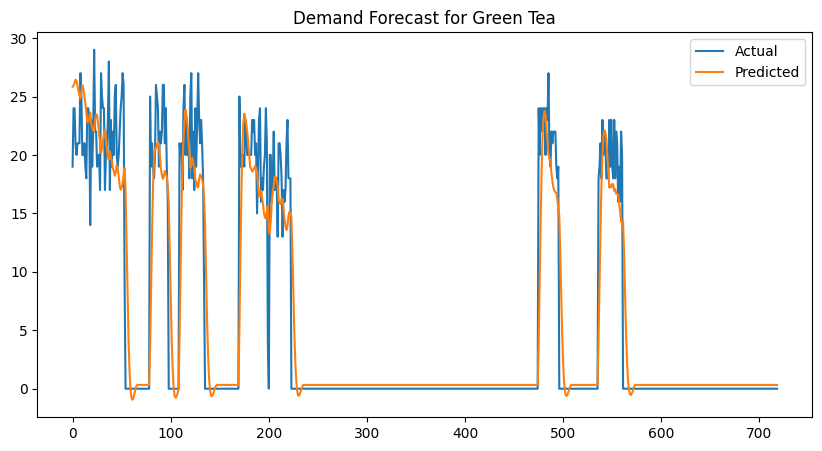

In [10]:
product = 'Green Tea'  
X, y = sequences[product]
model = train_model(product, X, y)

model.eval()
with torch.no_grad():
    predictions = model(X).numpy()
    actual = y.numpy()

scaler = scalers[product]
predicted_item_sold = scaler.inverse_transform(np.hstack((predictions, np.zeros((len(predictions), 2)))))[:, 0]
actual_item_sold = scaler.inverse_transform(np.hstack((actual, np.zeros((len(actual), 2)))))[:, 0]

plt.figure(figsize=(10, 5))
plt.plot(actual_item_sold, label='Actual')
plt.plot(predicted_item_sold, label='Predicted')
plt.title(f'Demand Forecast for {product}')
plt.legend()
plt.show()